In [97]:
import numpy as np
import scipy
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# prepare data
train_data_features = np.loadtxt(fname="train_data.txt",dtype=float,delimiter=',', usecols = (0,1))
train_data_target = np.loadtxt(fname="train_data.txt",dtype=float,delimiter=',', usecols = 2)
X_test = np.loadtxt(fname="test_data.txt",dtype=float,delimiter=',', usecols = (0,1))
Y_test = np.loadtxt(fname="test_data.txt",dtype=float,delimiter=',', usecols = 2)


In [98]:
# intitalize params

def init_params(dim):
    dim = [2,3,3,2]
    parameters = {}
    
    layers = len(dim)
    print ("layers:",layers)
    
    for i in range(1,layers):
        parameters['W' + str(i)] = np.matrix(np.random.rand(dim[i],dim[i-1]))
    return parameters
    
     
params = init_params('dim')
print (params)


layers: 4
{'W1': matrix([[0.91732521, 0.24366282],
        [0.22695608, 0.13566109],
        [0.08319326, 0.03149661]]), 'W2': matrix([[0.31371914, 0.34873642, 0.31119451],
        [0.57211365, 0.85650461, 0.95483763],
        [0.71097728, 0.81796371, 0.95078436]]), 'W3': matrix([[0.43568707, 0.38956284, 0.79545481],
        [0.03845922, 0.11334366, 0.54581169]])}


In [101]:
'''def sigmoid(z):
    s = 1/ (1 + np.exp(-z))
    return s
'''

def relu(z):
    if z.any() >= 0:
        return z
    elif z.any() <0:
        return 0
    
#relu = lambda z: z if z>=0 else 0

In [102]:
def grad_relu(s):
    jacobian_m = np.zeros((s.shape[0], s.shape[0])) # For 3*1 vector, jacobian is 3*3 matrix
    for i in range(len(jacobian_m)):
        for j in range(len(jacobian_m)):    
            if i == j:               
                jacobian_m[i,j] = s[i] * (1 - (s[i]))
            else:
                jacobian_m[i,j] = 0          
    return jacobian_m    

In [103]:
def grad_softmax(s):
# initialize the 2-D jacobian matrix.
    jacobian_m = np.zeros((s.shape[0], s.shape[0])) #  For 2*1 vector, jacobian is 2*2 matrix
    for i in range(len(jacobian_m)):
        for j in range(len(jacobian_m)):
            if i == j:
                #print (" s[i] :",  s[i])
                jacobian_m[i][j] = s[i] * (1-s[i])
            else: 
                jacobian_m[i][j] = -s[i]*s[j]
    return jacobian_m



In [104]:
def softmax(Z3):
    k = 0
    for i in range(len(Z3)):
        k += np.exp(Z3[i])
    for i in range(len(Z3)):
        Z3[i] = np.exp(Z3[i])/k
    return Z3
   

In [129]:
def forward_prop(W1,W2,W3,train_data_features):       
    Z1 = np.dot(W1, np.matrix(train_data_features).T)
    # W1 = 3 * 2
    #train_feature = 1 * 2
    #Z1 = 3 *1

    A1 = relu(Z1)
    
    # define a mask with same size as weight matrix 
    K2 = np.random.rand(W2.shape[0], W2.shape[1])  
    #print ("K2 orig:", K2) 
    '''
    for i,v in enumerate(K2):
        #print (type(i))
        #print (type(v))
        if v.any() <=0.5:
            K2[i] = 0
        else:
            K2[i] = 1
    '''
    #add drop outs by converting the some values of mask to zeroes to be multipled to wt matrix
    threshold = 0.5
    K2 = (K2 < threshold).astype(int)
    #print ("K2 after modify:", K2)

    
    W2 = np.array(W2) * np.array(K2)
    #print ("W2 after droput:", W2)
    

    Z2 = np.dot(W2, A1)
    #Z2 = np.dot(W2, A1)
    A2 = relu(Z2)

    #W2 = 3 * 3
    #A1 = 3 * 1
    #Z2 = 3 * 1
    #A2 = 3 * 1
    
    ### create a mask matrix to mask activation of A1 with drop out
    #K2 = np.random.rand(A2.shape[0], A2.shape[1])
    #K2 = (K2 < 0.7).astype(int)
    #A2 = A2 * K2
    
    
   
    
    

    Z3 = np.dot(W3,A2)
    #Z3 = np.dot(W3,A2)
    #W3 = 2 * 3
    #A2 = 3 * 1
    #Z3 = 2 * 1

    y_hat = softmax(Z3)
    #y_hat = 2 * 1
    
    return K2,A1,A2,y_hat

In [130]:
def optimise(K2,A1,A2,W1,W2,W3,y_hat,train_data_target,train_data_features,learning_rate):
    
    loss = np.sum(np.square(train_data_target - y_hat))

    # train_data_features = 1 * 2
    # y_hat = 2 * 1
    #loss = 1 *2 

    change_loss = -2 *(np.transpose(train_data_target)-y_hat)
    #change_loss = 2 *1

    delta_3 = np.dot(np.matrix(grad_softmax(y_hat)),change_loss)

    #delta_3 = 2*1
    #A2 = 3 * 1

    dW3 = np.multiply (A2,delta_3.T)

    #dw3 = 3 *2
    #A2 = 3 * 1
    #W3 = 2 * 3
    #1* 2

    delta_2 = np.dot(np.dot(grad_relu(A2),W3.T), delta_3)
    #print ("delta 2 orig shape:", delta_2.shape)
    ## (3 * 1) * (3 * 2) * (2 * 1)
    
    
    # 3*1 = 3*1 1*1

    dW2 = np.dot(A1, delta_2.T)
    #Multiply with the same mask as forward prop
    dW2 =  np.array(dW2) * np.array(K2)

    delta_1 = np.dot(np.dot(grad_relu(A1),np.transpose(W2)), delta_2)

    dW1 = np.dot(np.transpose(np.matrix(train_data_features)), delta_1.T)

    W1 = W1 -learning_rate * np.transpose(dW1)
    W2 = W2- learning_rate * dW2.T
    W3 = W3 - learning_rate * dW3.T        
    return  W1,W2,W3,loss
    

In [131]:
def train (train_data_features,train_data_target):
    epochs = 50
    learning_rate = 0.01
    loss_list =[]
    W1 = params['W1']
    W2 = params['W2']
    W3 = params['W3']

    for i in range(1,epochs):
        for j in range(len(train_data_features)):         
            K2,A1,A2,y_hat = forward_prop(W1,W2,W3,train_data_features[j])
            W1,W2,W3,loss=optimise(K2,A1,A2,W1,W2,W3,y_hat,train_data_target[j],train_data_features[j],learning_rate) 
        
        print("The Loss after " +str(i)+ " epochs: ", loss )
        loss_list.append(loss)
        #print ("loss list:", loss_list)
    return W1,W2,W3,loss_list
        
        


In [136]:
W1_final, W2_final, W3_final, loss_list = train(train_data_features,train_data_target)
print ("Final Wts 1:", W1_final.shape)
print ("Final Wts 2:", W2_final.shape)
print ("Final Wts 3:", W3_final.shape)

## Divide final weights by 2/3 
multiply_mat_1 = np.full((3, 2), 0.67)
multiply_mat_2 = np.full((3, 3), 0.67)
multiply_mat_3 = np.full((2, 3), 0.67)

W1_final = np.array(W1_final) * multiply_mat_1
W2_final = np.array(W2_final) * multiply_mat_2
W3_final = np.array(W3_final) * multiply_mat_3



The Loss after 1 epochs:  0.502944953562907
The Loss after 2 epochs:  0.5001060386543216
The Loss after 3 epochs:  0.5004793272842332
The Loss after 4 epochs:  0.5004666514427821
The Loss after 5 epochs:  0.5000369271319016
The Loss after 6 epochs:  0.5002332821230151
The Loss after 7 epochs:  0.5002222057191594
The Loss after 8 epochs:  0.5001445833254887
The Loss after 9 epochs:  0.5000592044451054
The Loss after 10 epochs:  0.5000053145709947
The Loss after 11 epochs:  0.5000001095074638
The Loss after 12 epochs:  0.5000553606643865
The Loss after 13 epochs:  0.5001759751231271
The Loss after 14 epochs:  0.5000001787633556
The Loss after 15 epochs:  0.5000110941259811
The Loss after 16 epochs:  0.5000178943251944
The Loss after 17 epochs:  0.5000104111793005
The Loss after 18 epochs:  0.5000460016283762
The Loss after 19 epochs:  0.5000024036032563
The Loss after 20 epochs:  0.5000355493043681
The Loss after 21 epochs:  0.5000361582435189
The Loss after 22 epochs:  0.500000371312973

In [ ]:
print (loss_list)

Text(0, 0.5, 'loss')

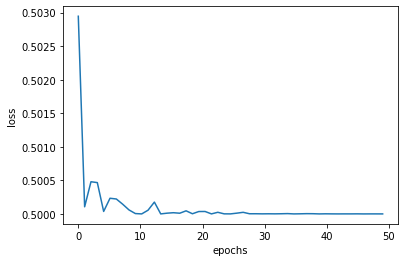

In [137]:
x = np.linspace(0,49,49)
y = loss_list
plt.plot(x,y)
plt.xlabel('epochs')
plt.ylabel('loss')


In [138]:
from sklearn import metrics
true_val = []
pred_val = []
     
for j in range(len(X_test)):
    K2,A1,A2,y_hat = forward_prop(W1_final,W2_final,W3_final,X_test[j])   
    y_hat = np.squeeze(np.asarray(y_hat))
    y_true = Y_test[j]
    y_true = np.squeeze(np.asarray(y_true))

    if y_true == 1:
        true_val.append("1")
    else:
        true_val.append("0")

    if y_hat[0] >y_hat[1]:
        pred_val.append("1")

    else:
        pred_val.append("0")

confusion_matric = confusion_matrix(true_val, pred_val)
tn, fp, fn, tp = confusion_matric.ravel()
#print (tn, fp, fn, tp)

precision = tp/(tp + fp)
recall = tp/(tp + fn)
f1_score = (precision * recall)/(precision + recall)
print ("precision:", precision)
print ("recall:", recall)
print ("F1 score:", f1_score)
    





precision: 0.4898785425101215
recall: 0.484
F1 score: 0.24346076458752516


In [ ]:
# observations after changing to RELU activaion and adding drop outs
New precision recall values are 49 percent and 48 percent respectively.
The loss vs epoch graph is also showing some fluctuations with increase in epochs.